# Flame Speed with Convergence Analysis

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Estimate the uncertainty in the laminar burning velocity calculation, due to grid size.

*The error estimation and convergence analysis was developed and contributed by Richard West <r.west@northeastern.edu> in 2019. Please acknowledge it as such if you use it.*

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

### Import Modules

In [1]:
import cantera as ct
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

from IPython.display import display, HTML

import scipy
import scipy.optimize

print(f"Running Cantera Version: {ct.__version__}")

Running Cantera Version: 2.6.0a4


In [2]:
# Import plotting modules and define plotting preference

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.figsize"] = (8, 6)

# Get the best of both ggplot and seaborn
plt.style.use("ggplot")
plt.style.use("seaborn-deep")

plt.rcParams["figure.autolayout"] = True

## Estimate uncertainty from grid size and speeds

In [3]:
def extrapolate_uncertainty(grids, speeds, plot=True):
    """
    Given a list of grid sizes and a corresponding list of flame speeds,
    extrapolate and estimate the uncertainty in the final flame speed.
    Also makes a plot, unless called with `plot=False`.
    """
    grids = list(grids)
    speeds = list(speeds)

    def speed_from_grid_size(grid_size, true_speed, error):
        """
        Given a grid size (or an array or list of grid sizes)
        return a prediction (or array of predictions)
        of the computed flame speed, based on
        the parameters `true_speed` and `error`.

        It seems, from experience, that error scales roughly with
        1/grid_size, so we assume that form.
        """
        return true_speed + error / np.array(grid_size)

    # Fit the chosen form of speed_from_grid_size, to the last four
    # speed and grid size values.
    popt, pcov = scipy.optimize.curve_fit(speed_from_grid_size, grids[-4:], speeds[-4:])

    # How bad the fit was gives you some error, `percent_error_in_true_speed`.
    perr = np.sqrt(np.diag(pcov))
    true_speed_estimate = popt[0]
    percent_error_in_true_speed = perr[0] / popt[0]
    print(
        f"Fitted true_speed is {popt[0] * 100:.4f} ± {perr[0] * 100:.4f} cm/s "
        f"({percent_error_in_true_speed:.1%})"
    )

    # How far your extrapolated infinite grid value is from your extrapolated
    # (or interpolated) final grid value, gives you some other error, `estimated_percent_error`
    estimated_percent_error = (
        speed_from_grid_size(grids[-1], *popt) - true_speed_estimate
    ) / true_speed_estimate
    print(f"Estimated error in final calculation {estimated_percent_error:.1%}")

    # The total estimated error is the sum of these two errors.
    total_percent_error_estimate = abs(percent_error_in_true_speed) + abs(
        estimated_percent_error
    )
    print(f"Estimated total error {total_percent_error_estimate:.1%}")

    if plot:
        plt.semilogx(grids, speeds, "o-")
        plt.ylim(
            min(speeds[-5:] + [true_speed_estimate - perr[0]]) * 0.95,
            max(speeds[-5:] + [true_speed_estimate + perr[0]]) * 1.05,
        )
        plt.plot(grids[-4:], speeds[-4:], "or")
        extrapolated_grids = grids + [grids[-1] * i for i in range(2, 8)]
        plt.plot(
            extrapolated_grids, speed_from_grid_size(extrapolated_grids, *popt), ":r"
        )
        plt.xlim(*plt.xlim())
        plt.hlines(true_speed_estimate, *plt.xlim(), colors="r", linestyles="dashed")
        plt.hlines(
            true_speed_estimate + perr[0],
            *plt.xlim(),
            colors="r",
            linestyles="dashed",
            alpha=0.3,
        )
        plt.hlines(
            true_speed_estimate - perr[0],
            *plt.xlim(),
            colors="r",
            linestyles="dashed",
            alpha=0.3,
        )
        plt.fill_between(
            plt.xlim(),
            true_speed_estimate - perr[0],
            true_speed_estimate + perr[0],
            facecolor="red",
            alpha=0.1,
        )

        above = popt[1] / abs(
            popt[1]
        )  # will be +1 if approach from above or -1 if approach from below

        plt.annotate(
            "",
            xy=(grids[-1], true_speed_estimate),
            xycoords="data",
            xytext=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
            textcoords="data",
            arrowprops=dict(
                arrowstyle="|-|, widthA=0.5, widthB=0.5",
                linewidth=1,
                connectionstyle="arc3",
                color="black",
                shrinkA=0,
                shrinkB=0,
            ),
        )

        plt.annotate(
            f"{abs(estimated_percent_error):.1%}",
            xy=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
            xycoords="data",
            xytext=(5, 15 * above),
            va="center",
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        plt.annotate(
            "",
            xy=(grids[-1] * 4, true_speed_estimate - (above * perr[0])),
            xycoords="data",
            xytext=(grids[-1] * 4, true_speed_estimate),
            textcoords="data",
            arrowprops=dict(
                arrowstyle="|-|, widthA=0.5, widthB=0.5",
                linewidth=1,
                connectionstyle="arc3",
                color="black",
                shrinkA=0,
                shrinkB=0,
            ),
        )
        plt.annotate(
            f"{abs(percent_error_in_true_speed):.1%}",
            xy=(grids[-1] * 4, true_speed_estimate - (above * perr[0])),
            xycoords="data",
            xytext=(5, -15 * above),
            va="center",
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
        )

        plt.ylabel("Flame speed (m/s)")
        plt.xlabel("Grid size")
        plt.show()

    return true_speed_estimate, total_percent_error_estimate

In [4]:
def make_callback(flame):
    """
    Create and return a callback function that you will attach to
    a flame solver. The reason we define a function to make the callback function,
    instead of just defining the callback function, is so that it can store
    a pair of lists that persist between function calls, to store the
    values of grid size and flame speed.

    This factory returns the callback function, and the two lists:
    (callback, speeds, grids)
    """
    speeds = []
    grids = []

    def callback(_):
        speed = flame.velocity[0]
        grid = len(flame.grid)
        speeds.append(speed)
        grids.append(grid)
        print(f"Iteration {len(grids)}")
        print(f"Current flame speed is is {speed * 100:.4f} cm/s")
        if len(grids) < 5:
            return 1.0  #
        try:
            extrapolate_uncertainty(grids, speeds)
        except Exception as e:
            print("Couldn't estimate uncertainty. " + str(e))
            return 1.0  # continue anyway
        return 1.0

    return callback, speeds, grids

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [5]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
gas = ct.Solution("gri30.yaml")

# Create a stoichiometric CH4/Air premixed mixture
gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [6]:
# Domain width in metres
width = 0.014

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define logging level
loglevel = 1

# Define tight tolerances for the solver
refine_criteria = {"ratio": 2, "slope": 0.01, "curve": 0.01}
flame.set_refine_criteria(**refine_criteria)

# Set maxiumum number of grid points to be very high (otherwise default is 1000)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

In [7]:
# Set up the the callback function and lists of speeds and grids
callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

### Solve

After the first five iterations, it will start to estimate the uncertainty.


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.029
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.674
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.122
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

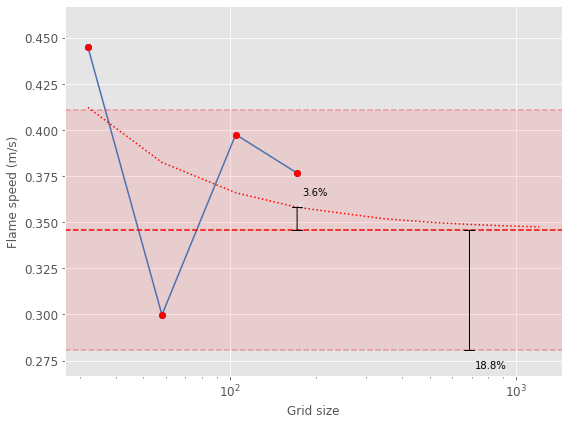


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 86 169 170 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 N2O NCO NO NO2 O O2 OH T point 86 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [226] point grid(s).
Iteration 6
Current flame speed is is 37.3130 cm/s
Fitted true_speed is 41.7019 ± 3.2857 cm/s (7.9%)
Estimated error in final

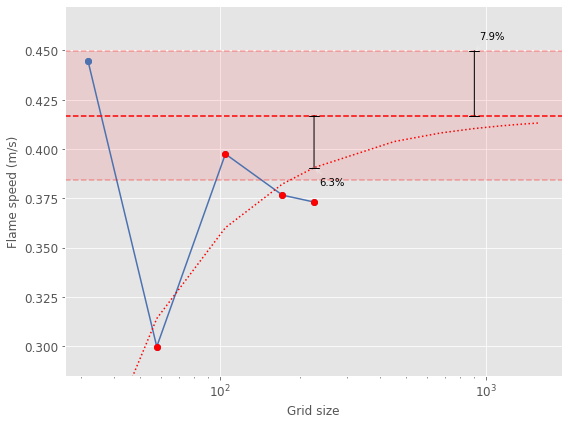


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 106 222 223 224 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 N2O NCO NO NO2 O O2 OH T point 106 point 19 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [289] point grid(s).
Iteration 7
Current flame speed is is 37.2613 cm/s
Fitted true_speed is 35.4841 ± 0.45

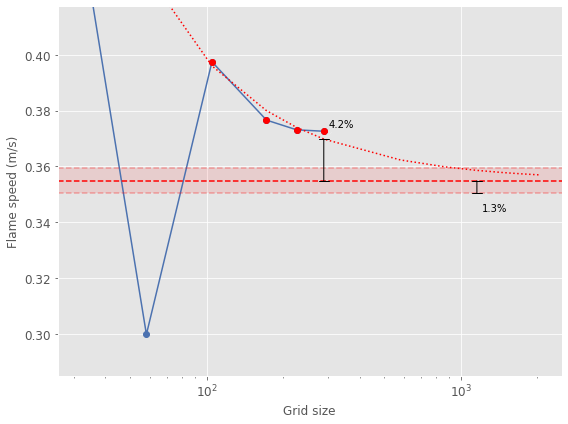


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 281 286 287 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N2 NO NO2 O O2 OH T point 281 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [369] point grid(s).
Iteration 8
Current flame speed is is 37.

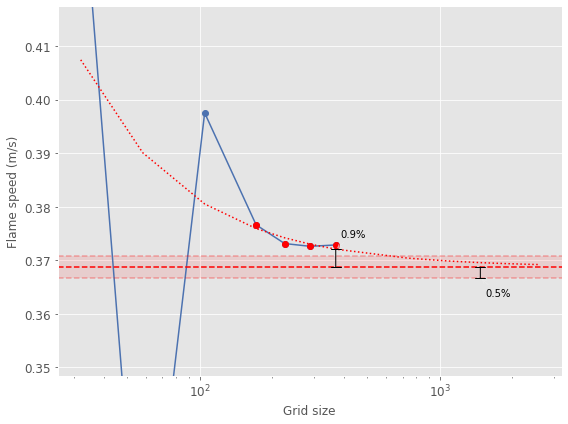


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 36 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 191 357 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCO HNCO HO2 N2 NO NO2 O O2 OH T point 191 point 357 point 36 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    succ

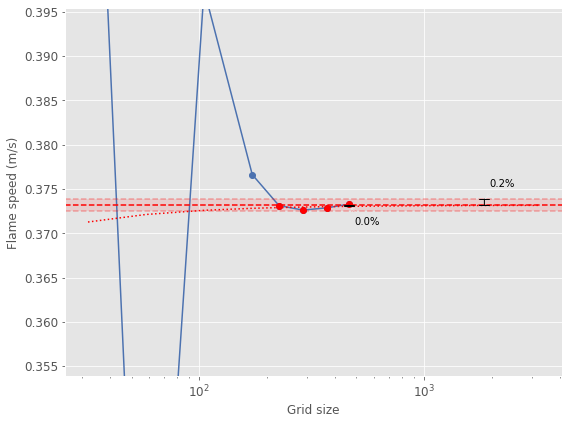


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 
    to resolve C C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCO HO2 N2 NO2 O O2 OH T velocity 
################################################

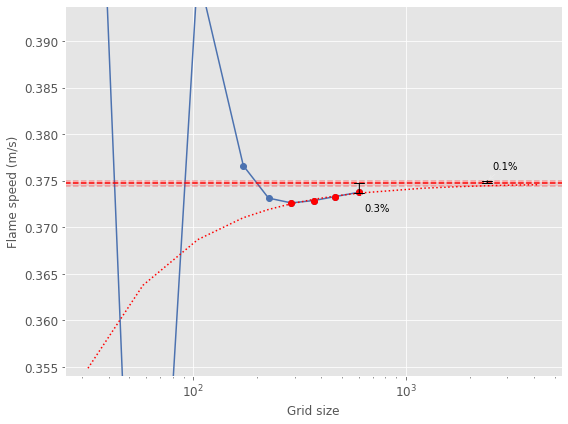


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 74 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 

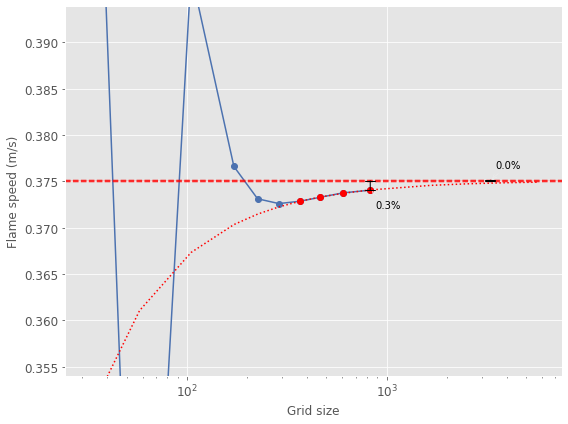


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421

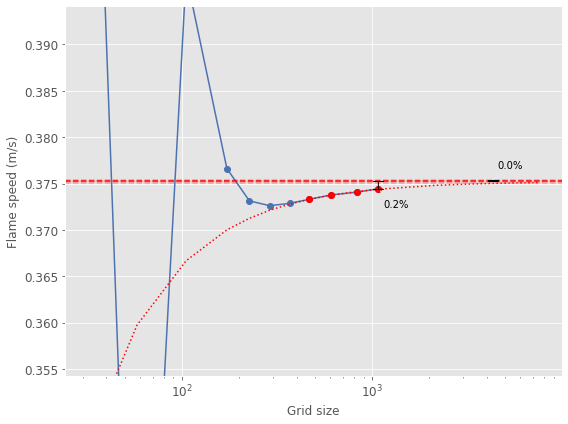


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 726 
    to resolve point 726 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [1078] point grid(s).
Iteration 13
Current flame speed is is 37.4470 cm/s
Fitted true_speed is 37.5311 ± 0.0161 cm/s (0.0%)
Estimated error in final calculation -0.2%
Estimated total error 0.3%


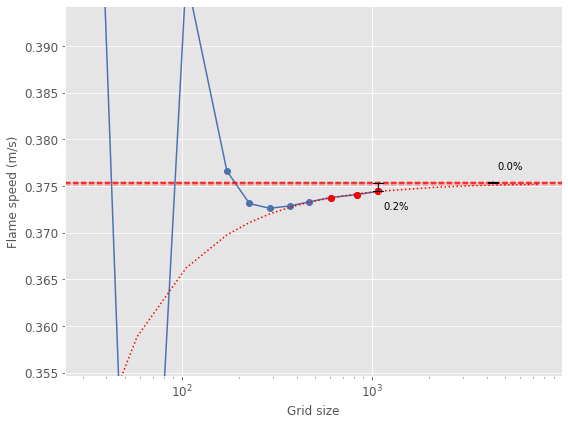


..............................................................................
no new points needed in flame
Flame Speed is: 37.45 cm/s


In [8]:
flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

Use the final lists of grid sizes and flame speeds to make one final extrapolation "best guess" 

Fitted true_speed is 37.5311 ± 0.0161 cm/s (0.0%)
Estimated error in final calculation -0.2%
Estimated total error 0.3%


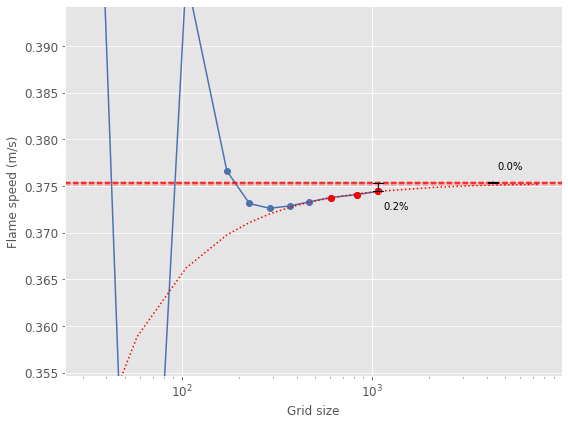

0.37531075653934487

In [9]:
best_true_speed_estimate, best_total_percent_error_estimate = extrapolate_uncertainty(
    grids, speeds
)

best_true_speed_estimate

## Analyze the error predictions
Now let's see how good our error estimates were, with hindsight.

If we assume that the final answer, with a very fine grid, has actually converged
and is is the "truth", then we can find out how large the errors were in the previous values, 
and compare these with our estimated errors. This will show if our estimates are reasonable, 
or conservative, or too optimistic.

In [16]:
def analyze_errors(grids, speeds, true_speed):
    """
    If we assume that the final answer, with a very fine grid,
    has actually converged and is is the "truth", then we can
    find out how large the errors were in the previous values,
    and compare these with our estimated errors.
    This will show if our estimates are reasonable, or conservative, or too optimistic.
    """
    true_speed_estimates = np.full_like(speeds, np.NaN)
    total_percent_error_estimates = np.full_like(speeds, np.NaN)
    actual_extrapolated_percent_errors = np.full_like(speeds, np.NaN)
    actual_raw_percent_errors = np.full_like(speeds, np.NaN)
    for i in range(3, len(grids)):
        print(grids[: i + 1])
        true_speed_estimate, total_percent_error_estimate = extrapolate_uncertainty(
            grids[: i + 1], speeds[: i + 1], plot=False
        )
        actual_extrapolated_percent_error = (
            abs(true_speed_estimate - true_speed) / true_speed
        )
        actual_raw_percent_error = abs(speeds[i] - true_speed) / true_speed
        print(
            "Actual extrapolated error (with hindsight) "
            f"{actual_extrapolated_percent_error:.1%}"
        )
        print(f"Actual raw error (with hindsight) {actual_raw_percent_error:.1%}")

        true_speed_estimates[i] = true_speed_estimate
        total_percent_error_estimates[i] = total_percent_error_estimate
        actual_extrapolated_percent_errors[i] = actual_extrapolated_percent_error
        actual_raw_percent_errors[i] = actual_raw_percent_error
        print()

    plt.loglog(grids, actual_raw_percent_errors * 100, "o-", label="raw error")
    plt.loglog(
        grids,
        actual_extrapolated_percent_errors * 100,
        "o-",
        label="extrapolated error",
    )
    plt.loglog(
        grids, total_percent_error_estimates * 100, "o-", label="estimated error"
    )
    plt.ylabel("Error in flame speed (%)")
    plt.xlabel("Grid size")
    plt.legend()
    plt.title(flame.get_refine_criteria())
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter())
    plt.show()
    flame.get_refine_criteria()

    data = pd.DataFrame(
        data={
            "actual error in raw value": actual_raw_percent_errors * 100,
            "actual error in extrapolated value": actual_extrapolated_percent_errors
            * 100,
            "estimated error": total_percent_error_estimates * 100,
        },
        index=grids,
    )
    display(data)

[32, 32, 58, 105]
Fitted true_speed is 31.1041 ± 8.6223 cm/s (27.7%)
Estimated error in final calculation 11.7%
Estimated total error 39.5%
Actual extrapolated error (with hindsight) 17.1%
Actual raw error (with hindsight) 5.9%

[32, 32, 58, 105, 172]
Fitted true_speed is 34.5698 ± 6.5149 cm/s (18.8%)
Estimated error in final calculation 3.6%
Estimated total error 22.4%
Actual extrapolated error (with hindsight) 7.9%
Actual raw error (with hindsight) 0.3%

[32, 32, 58, 105, 172, 226]
Fitted true_speed is 41.7019 ± 3.2857 cm/s (7.9%)
Estimated error in final calculation -6.3%
Estimated total error 14.2%
Actual extrapolated error (with hindsight) 11.1%
Actual raw error (with hindsight) 0.6%

[32, 32, 58, 105, 172, 226, 289]
Fitted true_speed is 35.4841 ± 0.4509 cm/s (1.3%)
Estimated error in final calculation 4.2%
Estimated total error 5.5%
Actual extrapolated error (with hindsight) 5.5%
Actual raw error (with hindsight) 0.7%

[32, 32, 58, 105, 172, 226, 289, 369]
Fitted true_speed is 36

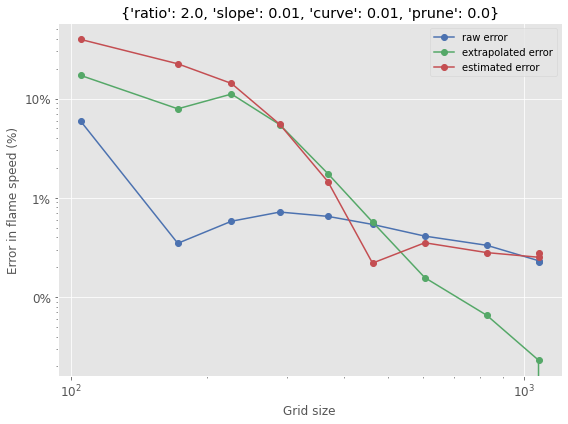

,actual error in raw value,actual error in extrapolated value,estimated error
32,NaN,NaN,NaN
32,NaN,NaN,NaN
58,NaN,NaN,NaN
105,5.915084,17.124319,39.468954
172,0.348239,7.890169,22.423468
226,0.581112,11.113093,14.217672
289,0.718922,5.454031,5.491014
369,0.650537,1.753594,1.457227
463,0.539655,0.570865,0.219938
604,0.411482,0.156980,0.352497


In [17]:
analyze_errors(grids, speeds, best_true_speed_estimate)

## Repeat with less tight refine criteria

In [18]:
refine_criteria = {"ratio": 3, "slope": 0.1, "curve": 0.1}


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.029
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.674
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.122
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

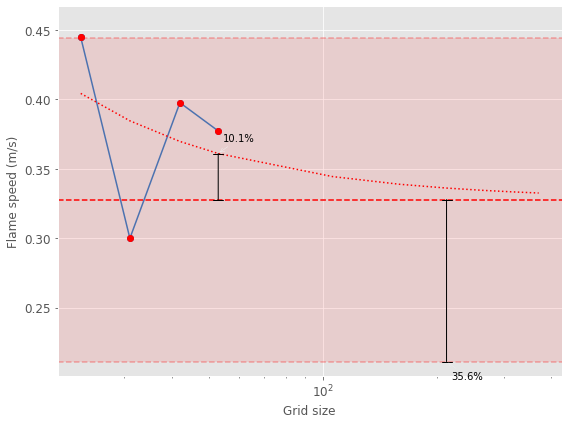


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 15 16 17 18 19 20 21 22 23 24 25 26 27 50 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 N2O NCO NO NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [67] point grid(s).
Iteration 6
Current flame speed is is 37.4891 cm/s
Fitted true_speed is 45.7925 ± 6.3741 cm/s (13.9%)
Estimated error in final calculation -13.9%
Estimated total error 27.8%


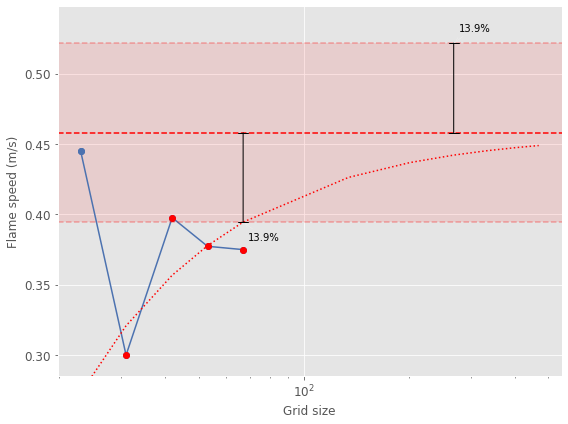


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 NO NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [85] point grid(s).
Iteration 7
Current flame speed is is 37.6430 cm/s
Fitted true_speed is 35.1215 ± 1.3939 cm/s (4.0%)
Estimated error in final calculation 5.9%
Estimated total error 9.8%


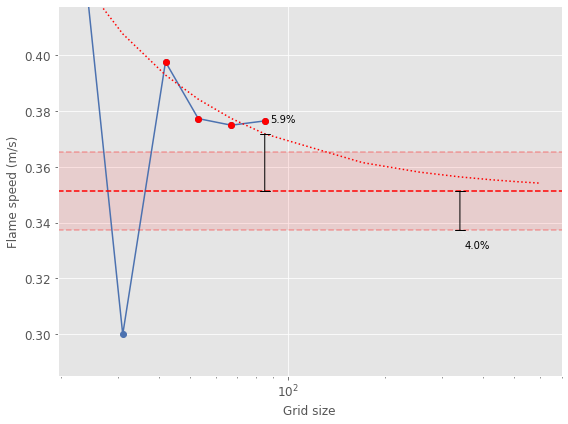


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO H H2 H2O H2O2 HCCO HCCOH HCN HCO HNCO HO2 N2 NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [113] point grid(s).
Iteration 8
Current flame speed is is 37.8970 cm/s
Fitted true_speed is 37.9278 ± 0.3533 cm/s (0.9%)
Estimated error in final calculation -0.4%
Estimated total error 1.3%


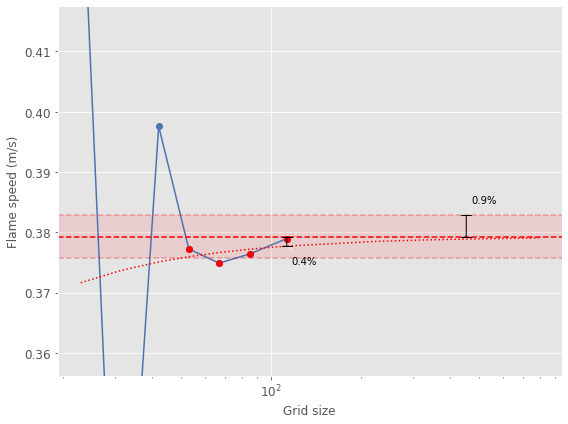


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 34 35 36 37 38 39 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
    to resolve C C2H2 C2H3 C2H4 C2H5 C2H6 C3H8 CH CH2 CH2(S) CH2CO CH2OH CH3 CH3CHO CH3O HCCO HCO 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [142] point grid(s).
Iteration 9
Current flame speed is is 38.2319 cm/s
Fitted true_speed is 38.7784 ± 0.2004 cm/s (0.5%)
Estimated error in final calculation -1.6%
Estimated total error 2.2%


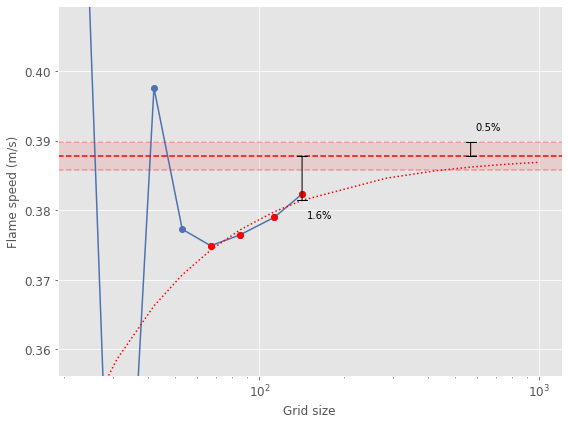


..............................................................................
no new points needed in flame
Flame Speed is: 38.23 cm/s


In [19]:
# Reset the gas
gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

[23, 23, 31, 42]
Fitted true_speed is 25.7317 ± 15.5178 cm/s (60.3%)
Estimated error in final calculation 36.1%
Estimated total error 96.4%
Actual extrapolated error (with hindsight) 31.4%
Actual raw error (with hindsight) 5.9%

[23, 23, 31, 42, 53]
Fitted true_speed is 32.7812 ± 11.6625 cm/s (35.6%)
Estimated error in final calculation 10.1%
Estimated total error 45.7%
Actual extrapolated error (with hindsight) 12.7%
Actual raw error (with hindsight) 0.5%

[23, 23, 31, 42, 53, 67]
Fitted true_speed is 45.7925 ± 6.3741 cm/s (13.9%)
Estimated error in final calculation -13.9%
Estimated total error 27.8%
Actual extrapolated error (with hindsight) 22.0%
Actual raw error (with hindsight) 0.1%

[23, 23, 31, 42, 53, 67, 85]
Fitted true_speed is 35.1215 ± 1.3939 cm/s (4.0%)
Estimated error in final calculation 5.9%
Estimated total error 9.8%
Actual extrapolated error (with hindsight) 6.4%
Actual raw error (with hindsight) 0.3%

[23, 23, 31, 42, 53, 67, 85, 113]
Fitted true_speed is 37.9278 ± 

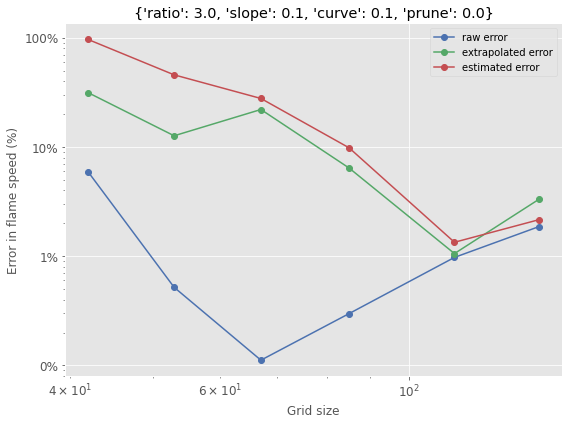

,actual error in raw value,actual error in extrapolated value,estimated error
23,NaN,NaN,NaN
23,NaN,NaN,NaN
31,NaN,NaN,NaN
42,5.935871,31.438978,96.383332
53,0.519098,12.655752,45.697973
67,0.111825,22.012258,27.776320
85,0.298172,6.420185,9.826740
113,0.975078,1.057040,1.341516
142,1.867447,3.323424,2.159880


In [20]:
# Use the best true speed estimate from the fine grid tight criteria above
analyze_errors(grids, speeds, best_true_speed_estimate)

## Default (loose) criteria

In [21]:
flame = ct.FreeFlame(gas, width=width)
flame.get_refine_criteria()
refine_criteria = flame.get_refine_criteria()
refine_criteria.update({"prune": 0})
refine_criteria

{'ratio': 10.0, 'slope': 0.8, 'curve': 0.8, 'prune': 0}


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.029
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.674
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.122
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

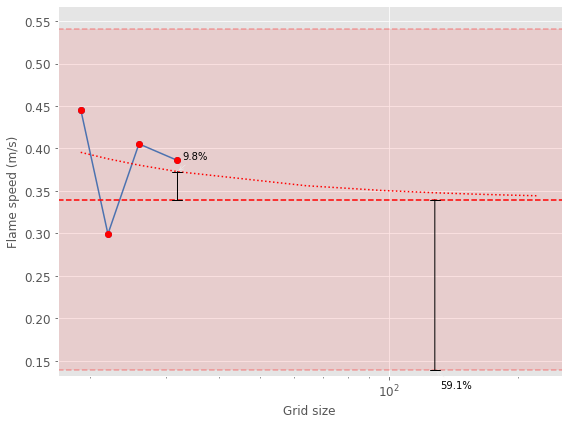


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 12 13 14 15 
    to resolve C C2H2 C2H3 C2H5 C3H7 C3H8 CH CH2 CH2(S) CH2OH HCCO HCO 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [36] point grid(s).
Iteration 6
Current flame speed is is 41.1471 cm/s
Fitted true_speed is 56.6805 ± 9.9888 cm/s (17.6%)
Estimated error in final calculation -26.2%
Estimated total error 43.9%


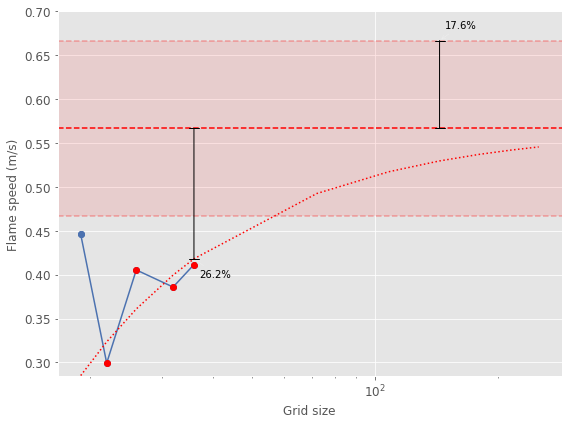


..............................................................................
no new points needed in flame
Flame Speed is: 41.15 cm/s


In [22]:
gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

[19, 19, 22, 26]
Fitted true_speed is 18.4813 ± 30.7668 cm/s (166.5%)
Estimated error in final calculation 94.3%
Estimated total error 260.8%
Actual extrapolated error (with hindsight) 50.8%
Actual raw error (with hindsight) 8.0%

[19, 19, 22, 26, 32]
Fitted true_speed is 33.9553 ± 20.0669 cm/s (59.1%)
Estimated error in final calculation 9.8%
Estimated total error 68.9%
Actual extrapolated error (with hindsight) 9.5%
Actual raw error (with hindsight) 2.8%

[19, 19, 22, 26, 32, 36]
Fitted true_speed is 56.6805 ± 9.9888 cm/s (17.6%)
Estimated error in final calculation -26.2%
Estimated total error 43.9%
Actual extrapolated error (with hindsight) 51.0%
Actual raw error (with hindsight) 9.6%



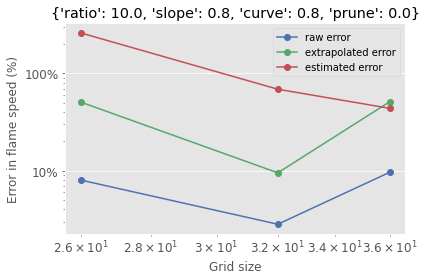

,actual error in raw value,actual error in extrapolated value,estimated error
19,NaN,NaN,NaN
19,NaN,NaN,NaN
22,NaN,NaN,NaN
26,8.020085,50.757471,260.769187
32,2.821832,9.527463,68.874039
36,9.634620,51.022940,43.855803


In [19]:
analyze_errors(grids, speeds, best_true_speed_estimate)

## Middling refine criteria

In [20]:
refine_criteria = {"ratio": 3, "slope": 0.1, "curve": 0.1}


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.029
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.674
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.122
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after gri

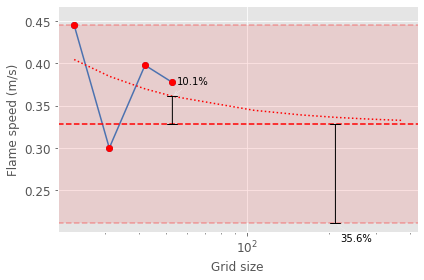


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 15 16 17 18 19 20 21 22 23 24 25 26 27 50 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 N2O NCO NO NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [67] point grid(s).
Iteration 6
Current flame speed is is 37.4891 cm/s
Fitted true_speed is 45.7925 ± 6.3741 cm/s (13.9%)
Estimated error in final calculation -13.9%
Estimated total error 27.8%


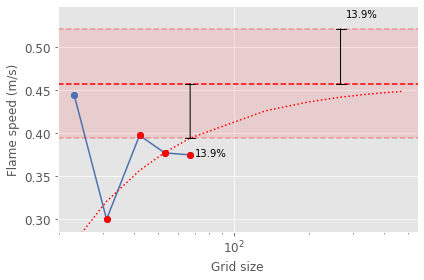


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 NO NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [85] point grid(s).
Iteration 7
Current flame speed is is 37.6430 cm/s
Fitted true_speed is 35.1215 ± 1.3939 cm/s (4.0%)
Estimated error in final calculation 5.9%
Estimated total error 9.8%


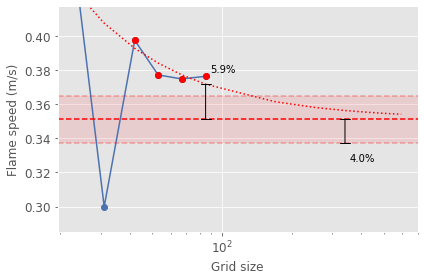


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO H H2 H2O H2O2 HCCO HCCOH HCN HCO HNCO HO2 N2 NO2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [113] point grid(s).
Iteration 8
Current flame speed is is 37.8970 cm/s
Fitted true_speed is 37.9278 ± 0.3533 cm/s (0.9%)
Estimated error in final calculation -0.4%
Estimated total error 1.3%


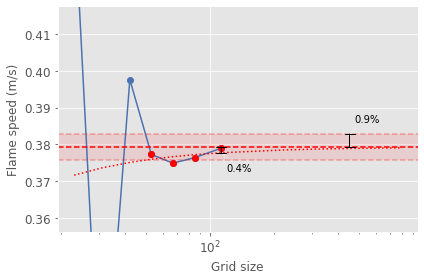


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 34 35 36 37 38 39 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
    to resolve C C2H2 C2H3 C2H4 C2H5 C2H6 C3H8 CH CH2 CH2(S) CH2CO CH2OH CH3 CH3CHO CH3O HCCO HCO 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [142] point grid(s).
Iteration 9
Current flame speed is is 38.2319 cm/s
Fitted true_speed is 38.7784 ± 0.2004 cm/s (0.5%)
Estimated error in final calculation -1.6%
Estimated total error 2.2%


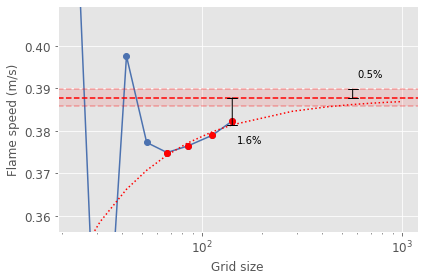


..............................................................................
no new points needed in flame
Flame Speed is: 38.23 cm/s


In [21]:
# Reset the gas
gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

[19, 19, 22, 26]
Fitted true_speed is 18.4813 ± 30.7668 cm/s (166.5%)
Estimated error in final calculation 94.3%
Estimated total error 260.8%
Actual extrapolated error (with hindsight) 50.8%
Actual raw error (with hindsight) 8.0%

[19, 19, 22, 26, 32]
Fitted true_speed is 33.9553 ± 20.0669 cm/s (59.1%)
Estimated error in final calculation 9.8%
Estimated total error 68.9%
Actual extrapolated error (with hindsight) 9.5%
Actual raw error (with hindsight) 2.8%

[19, 19, 22, 26, 32, 36]
Fitted true_speed is 56.6805 ± 9.9888 cm/s (17.6%)
Estimated error in final calculation -26.2%
Estimated total error 43.9%
Actual extrapolated error (with hindsight) 51.0%
Actual raw error (with hindsight) 9.6%



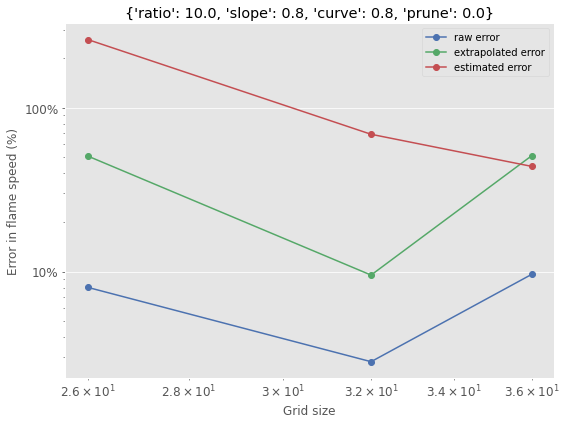

,actual error in raw value,actual error in extrapolated value,estimated error
19,NaN,NaN,NaN
19,NaN,NaN,NaN
22,NaN,NaN,NaN
26,8.020085,50.757467,260.769151
32,2.821832,9.527453,68.874022
36,9.634620,51.022939,43.855803


In [23]:
analyze_errors(grids, speeds, best_true_speed_estimate)

## Try a Hydrogen flame (still with GRI mech)

In [24]:
# Tight criteria
refine_criteria = {"ratio": 2, "slope": 0.01, "curve": 0.01}


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.746e-06      7.147
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001216      5.304
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve H H2 H2O H2O2 HO2 N N2 N2O NNH NO NO2 O O2 OH T point 0 point 6 velocity 
##############################################################################

*********** Solving on 17 point grid with energy equation enabled ************

..............................................

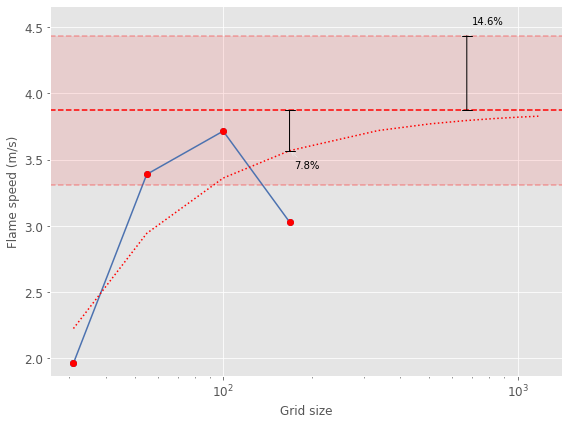


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 3 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 165 166 
    to resolve H H2 H2O H2O2 HO2 N N2 N2O NNH NO O O2 OH T point 3 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [211] point grid(s).
Iteration 6
Current flame speed is is 269.2327 cm/s
Fitted true_speed is 277.4906 ± 45.1457 cm/s (16.3%)
Estimated error in final calculation 7.6%
Estimated total error 23.9%


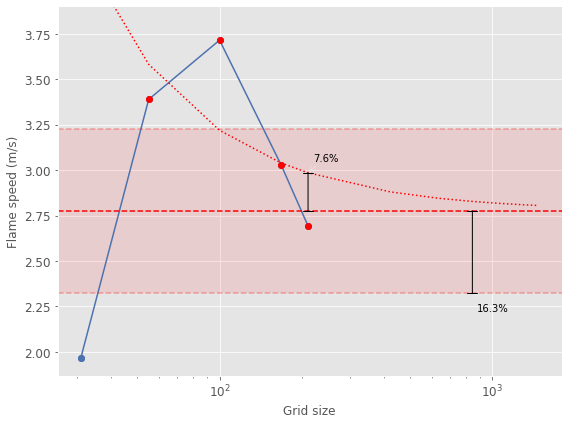


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 2 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 87 207 208 209 
    to resolve H H2 H2O H2O2 HO2 N2 N2O NO O O2 OH T point 18 point 2 point 87 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [258] point grid(s).
Iteration 7
Current flame speed is is 251.4201 cm/s
Fitted true_speed is 179.2537 ± 9.0126 cm/s (5.0%)
Estimated error in final calculation 42.1%
Estimated total error 47.1%


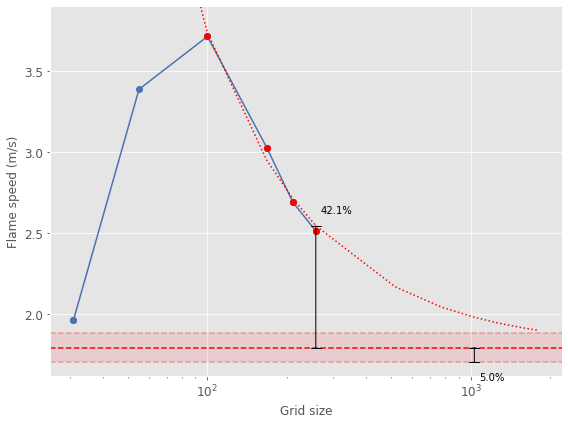


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 18 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 107 250 254 255 256 
    to resolve H H2 H2O H2O2 HO2 N2 NO O O2 OH T point 107 point 18 point 250 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [314] point grid(s).
Iteration 8
Current flame speed is is 242.3247 cm/s
Fitted true_speed is 167.9934 ± 10.3013 cm/s (6.1%)
Estimated error in final calculation 42.1%
Estimated total error 48.2%


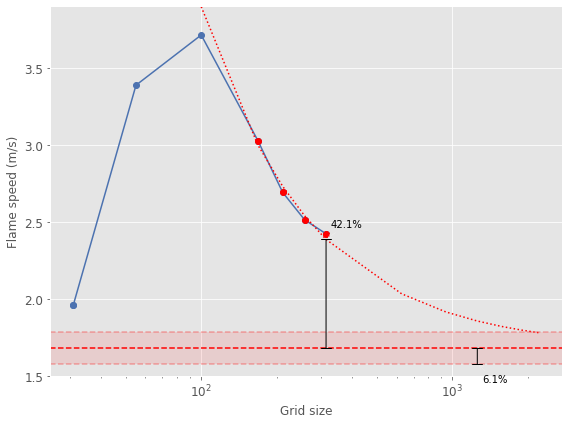


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 17 29 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 130 301 310 311 312 
    to resolve H H2 H2O H2O2 HO2 N2 NO O O2 OH T point 130 point 17 point 29 point 301 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [384] point grid(s).
Iteration 9
Current flame speed is is 237.6990 cm/s
Fitted true_speed is 196.6286 ± 7.4813 cm/s (3.8%)
Estimated error in final calculation 19.7%
Estimated total error 23.5%


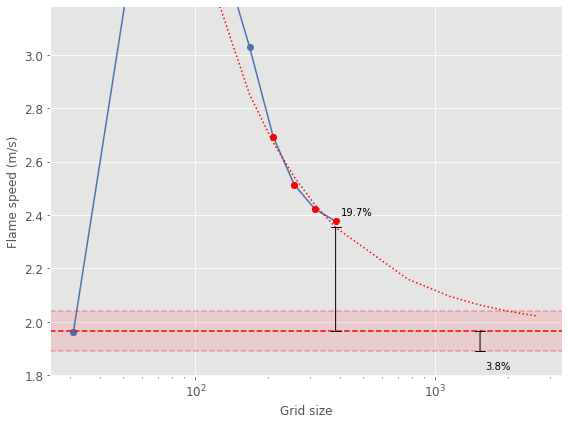


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 29 35 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 197 376 381 382 
    to resolve H H2 H2O H2O2 HO2 N2 NO O O2 OH T point 197 point 29 point 35 point 376 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [482] point grid(s).
Iteration 10
Current flame speed is is 235.3593 cm/s
Fitted true_speed is 215.4425

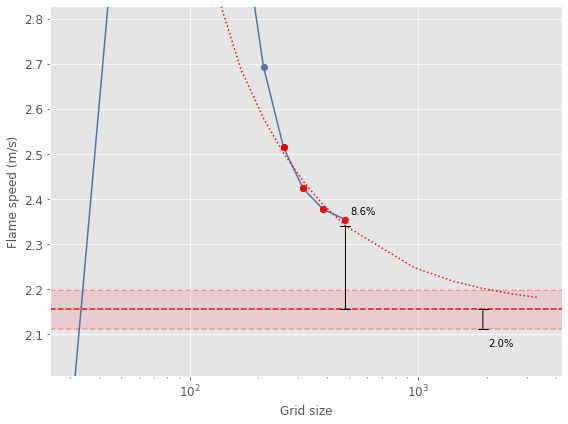


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 
    to resolve H H2 H2O H2O2 HO2 N2 O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solutio

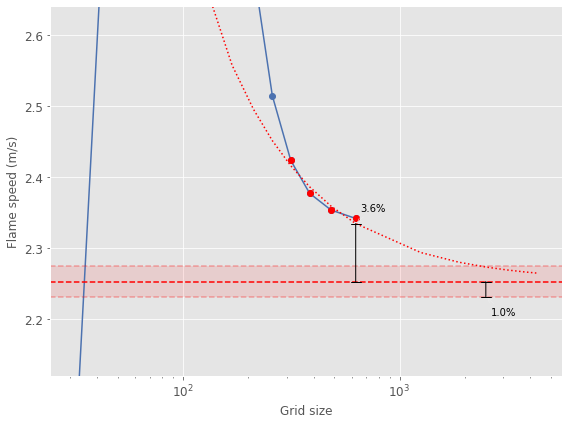


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 
    t

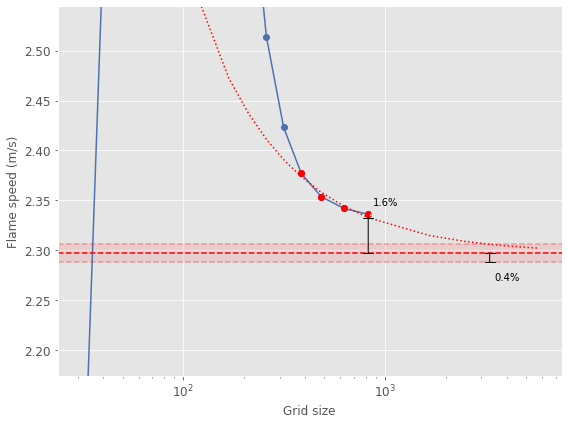


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 76 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 477 
    to resolve H2O2 HO2 OH T point 477 point 76 velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [942] point 

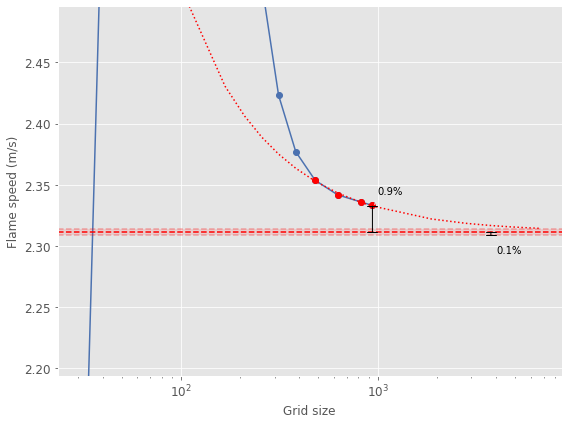


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 595 
    to resolve HO2 point 595 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [985] point grid(s).
Iteration 14
Current flame speed is is 233.2646 cm/s
Fitted true_speed is 231.6425 ± 0.0624 cm/s (0.0%)
Estimated error in final calculation 0.7%
Estimated total error 0.7%


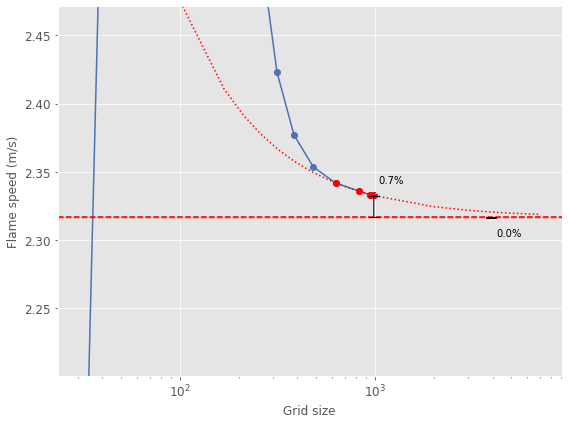


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 204 289 
    to resolve point 204 point 289 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [987] point grid(s).
Iteration 15
Current flame speed is is 233.2546 cm/s
Fitted true_speed is 231.5629 ± 0.1390 cm/s (0.1%)
Estimated error in final calculation 0.7%
Estimated total error 0.8%


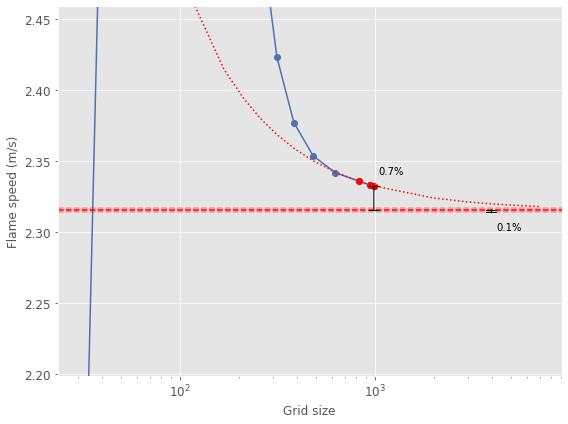


..............................................................................
no new points needed in flame
Flame Speed is: 233.25 cm/s


In [25]:
# Reset the gas
gas.set_equivalence_ratio(1.0, "H2", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

Fitted true_speed is 231.5629 ± 0.1390 cm/s (0.1%)
Estimated error in final calculation 0.7%
Estimated total error 0.8%


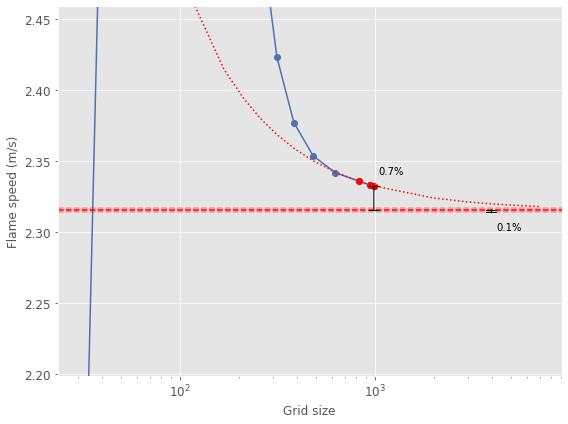

In [26]:
# get a new best true speed estimate
best_true_speed_estimate, best_total_percent_error_estimate = extrapolate_uncertainty(
    grids, speeds
)

[31, 31, 55, 100]
Fitted true_speed is 468.2309 ± 24.3647 cm/s (5.2%)
Estimated error in final calculation -17.7%
Estimated total error 22.9%
Actual extrapolated error (with hindsight) 102.2%
Actual raw error (with hindsight) 60.4%

[31, 31, 55, 100, 168]
Fitted true_speed is 387.1014 ± 56.3305 cm/s (14.6%)
Estimated error in final calculation -7.8%
Estimated total error 22.4%
Actual extrapolated error (with hindsight) 67.2%
Actual raw error (with hindsight) 30.8%

[31, 31, 55, 100, 168, 211]
Fitted true_speed is 277.4906 ± 45.1457 cm/s (16.3%)
Estimated error in final calculation 7.6%
Estimated total error 23.9%
Actual extrapolated error (with hindsight) 19.8%
Actual raw error (with hindsight) 16.3%

[31, 31, 55, 100, 168, 211, 258]
Fitted true_speed is 179.2537 ± 9.0126 cm/s (5.0%)
Estimated error in final calculation 42.1%
Estimated total error 47.1%
Actual extrapolated error (with hindsight) 22.6%
Actual raw error (with hindsight) 8.6%

[31, 31, 55, 100, 168, 211, 258, 314]
Fitted 

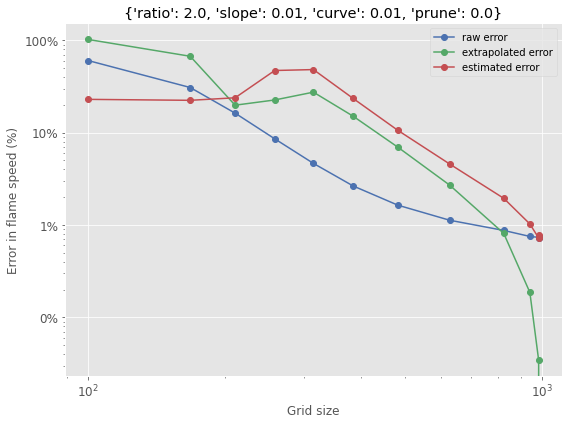

,actual error in raw value,actual error in extrapolated value,estimated error
31,NaN,NaN,NaN
31,NaN,NaN,NaN
55,NaN,NaN,NaN
100,60.433375,102.204601,22.938452
168,30.820987,67.168993,22.396288
211,16.267603,19.833797,23.852404
258,8.575273,22.589633,47.104781
314,4.647441,27.452357,48.199529
384,2.649840,15.086337,23.496173
482,1.639446,6.961591,10.594450


In [27]:
analyze_errors(grids, speeds, best_true_speed_estimate)

## Middling refine criteria, Hydrogen flame

In [28]:
refine_criteria = {"ratio": 3, "slope": 0.1, "curve": 0.1}


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.746e-06      7.147
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001216      5.304
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve H H2 H2O H2O2 HO2 N N2 N2O NNH NO NO2 O O2 OH T velocity 
##############################################################################

*********** Solving on 17 point grid with energy equation enabled ************

..............................................................

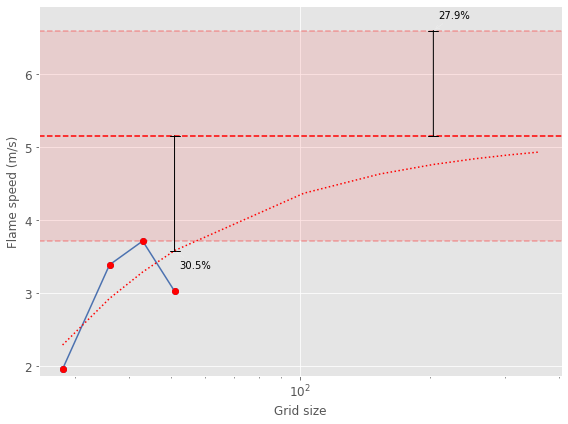


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 14 15 16 17 18 19 20 21 22 23 
    to resolve H H2 H2O H2O2 HO2 N2 N2O NNH NO O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [61] point grid(s).
Iteration 6
Current flame speed is is 269.2051 cm/s
Fitted true_speed is 169.2640 ± 90.5894 cm/s (53.5%)
Estimated error in final calculation 67.4%
Estimated total error 120.9%


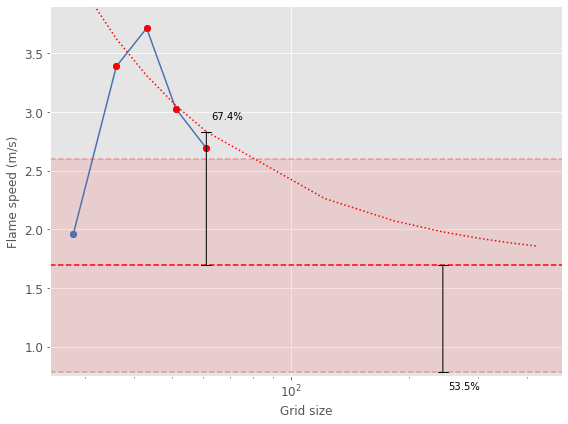


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 17 18 19 20 21 22 23 24 25 26 27 28 29 
    to resolve H H2 H2O H2O2 HO2 N2 NO O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [74] point grid(s).
Iteration 7
Current flame speed is is 251.2929 cm/s
Fitted true_speed is 74.8171 ± 37.9547 cm/s (50.7%)
Estimated error in final calculation 222.3%
Estimated total error 273.0%


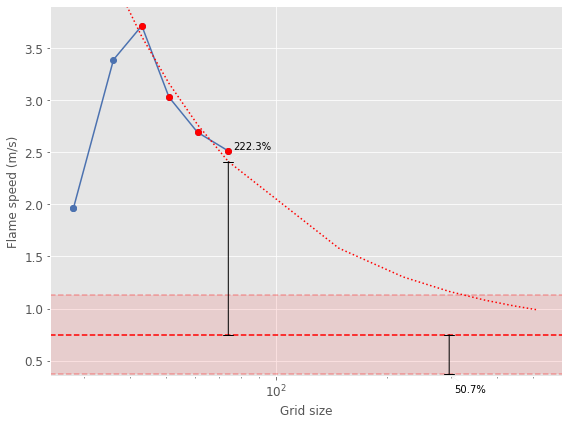


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 
    to resolve H H2 H2O H2O2 HO2 N2 NO O O2 OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [93] point grid(s).
Iteration 8
Current flame speed is is 242.1498 cm/s
Fitted true_speed is 163.0667 ± 17.8966 cm/s (11.0%)
Estimated error in final calculation 45.2%
Estimated total error 56.2%


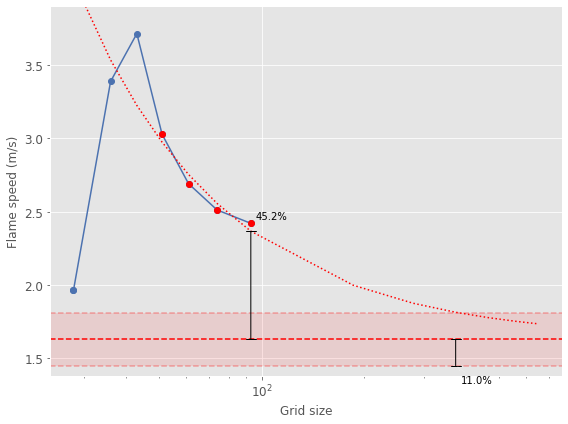


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 
    to resolve H2O2 HO2 N2 O OH T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [114] point grid(s).
Iteration 9
Current flame speed is is 237.2099 cm/s
Fitted true_speed is 198.5756 ± 7.6588 cm/s (3.9%)
Estimated error in final calculation 18.4%
Estimated total error 22.2%


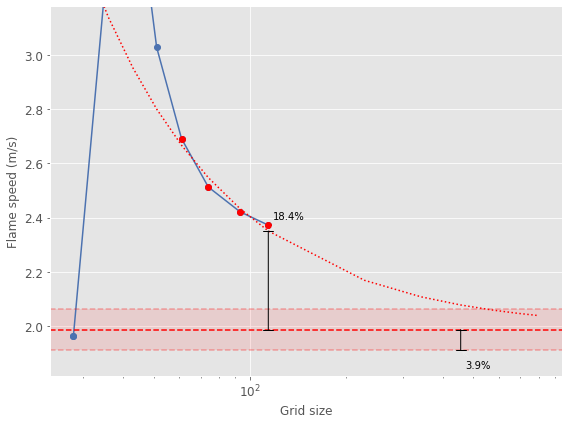


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 
    to resolve H2O2 HO2 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [129] point grid(s).
Iteration 10
Current flame speed is is 234.8569 cm/s
Fitted true_speed is 212.2393 ± 1.7472 cm/s (0.8%)
Estimated error in final calculation 10.4%
Estimated total error 11.3%


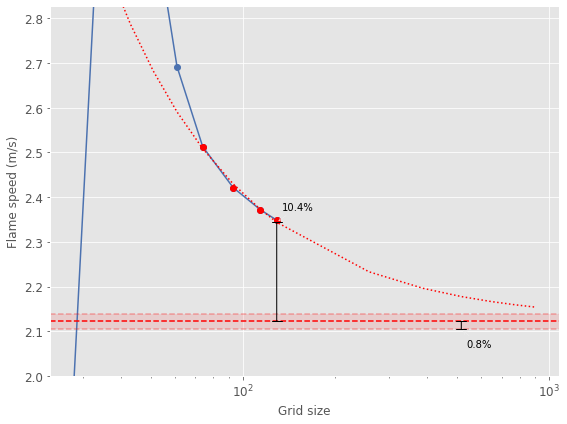


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 41 42 43 44 
    to resolve HO2 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [133] point grid(s).
Iteration 11
Current flame speed is is 234.6094 cm/s
Fitted true_speed is 216.5803 ± 0.7124 cm/s (0.3%)
Estimated error in final calculation 8.2%
Estimated total error 8.6%


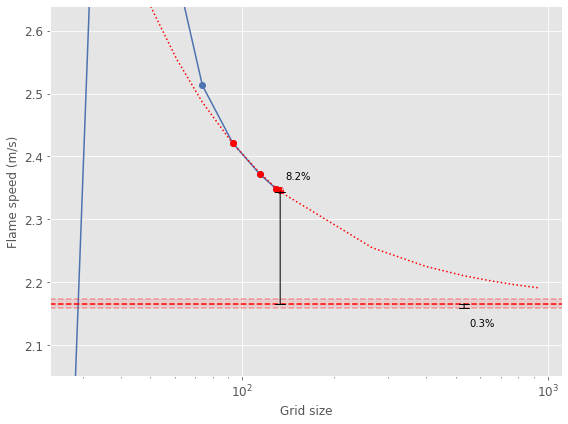


..............................................................................
no new points needed in flame
Flame Speed is: 234.61 cm/s


In [29]:
# Reset the gas
gas.set_equivalence_ratio(1.0, "H2", {"O2": 1.0, "N2": 3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index("flame")], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")

[28, 28, 36, 43]
Fitted true_speed is 729.6795 ± 52.4598 cm/s (7.2%)
Estimated error in final calculation -47.3%
Estimated total error 54.4%
Actual extrapolated error (with hindsight) 215.1%
Actual raw error (with hindsight) 60.4%

[28, 28, 36, 43, 51]
Fitted true_speed is 515.4742 ± 144.0158 cm/s (27.9%)
Estimated error in final calculation -30.5%
Estimated total error 58.4%
Actual extrapolated error (with hindsight) 122.6%
Actual raw error (with hindsight) 30.8%

[28, 28, 36, 43, 51, 61]
Fitted true_speed is 169.2640 ± 90.5894 cm/s (53.5%)
Estimated error in final calculation 67.4%
Estimated total error 120.9%
Actual extrapolated error (with hindsight) 26.9%
Actual raw error (with hindsight) 16.3%

[28, 28, 36, 43, 51, 61, 74]
Fitted true_speed is 74.8171 ± 37.9547 cm/s (50.7%)
Estimated error in final calculation 222.3%
Estimated total error 273.0%
Actual extrapolated error (with hindsight) 67.7%
Actual raw error (with hindsight) 8.5%

[28, 28, 36, 43, 51, 61, 74, 93]
Fitted true_sp

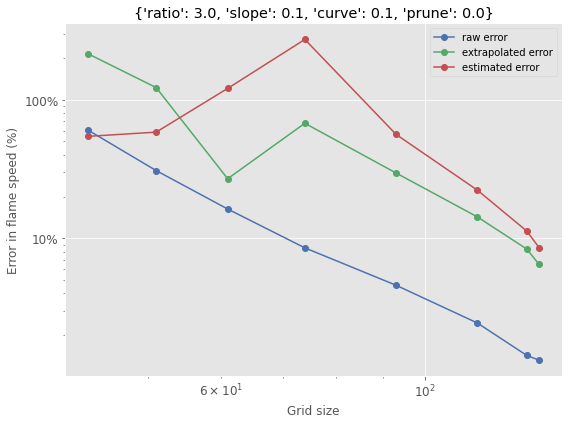

,actual error in raw value,actual error in extrapolated value,estimated error
28,NaN,NaN,NaN
28,NaN,NaN,NaN
36,NaN,NaN,NaN
43,60.433331,215.110671,54.440126
51,30.817708,122.606521,58.417576
61,16.255720,26.903686,120.895427
74,8.520372,67.690361,273.037255
93,4.571941,29.579963,56.196084
114,2.438634,14.245514,22.226241
129,1.422479,8.344867,11.259605


In [30]:
analyze_errors(grids, speeds, best_true_speed_estimate)